# Generación de piezas musicales con Autoencoder-CNN

## Setup

In [1]:
!pip install pypianoroll

In [2]:
import os
import numpy as np
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K 
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
#import tensorflow as tf
#import gc
#import pickle
from sklearn.model_selection import train_test_split
import pypianoroll as pr
import matplotlib.pyplot as plt

In [3]:
ENV = 'colab'
if(ENV == 'colab'):
    BASE_PATH = '/content/drive/MyDrive/uni/TFG2023/generative-music/'
    from google.colab import drive
    drive.mount('/content/drive')
    
elif(ENV == 'local'):
    BASE_PATH = './'
else:
    raise Exception()

Mounted at /content/drive


In [4]:
DATASET = 'cello'
DATA_PATH=os.path.join(BASE_PATH, 'data')
DATASET_PATH = os.path.join(DATA_PATH, DATASET)

STORE_PATH=os.path.join(BASE_PATH,'generated')

RANDOM_SEED=616
SEQ_LEN=32
RESOLUTION=2

### Clases para el preprocesamiento de los datos y la compilación del modelo

In [5]:
# CNNDatasetEncoder
class CNNDatasetEncoder:
    
    def __init__(self, path, seq_len=32, delimiter='/', blend_tracks=False):
        self.path = path
        self.parsed_files = self.load()
        self.seq_len = seq_len
        self.delimiter = delimiter
        self.blend_tracks = blend_tracks
    
    def load(self):
        
        # Get song data from data_path and parse it as a pypianoroll object
        songs = {}

        for path,subdir,files in os.walk(self.path):
            for file in files:
                if (file[-3:] == 'mid'):
                    try:
                        song = pr.read(os.path.join(path,file))
                        songs[file[:-4]] = song
                    except:
                        print(f'Parsing file {file} failed. Skipping.')
                        continue
        return songs
        
    def encode(self):
        encoded_files = {}
        titles, files = list(self.parsed_files.keys()), list(self.parsed_files.values())
        
        
        for i,file in enumerate(files):
            print(f'Processing song {titles[i]}')

            # Clean short songs
            if(file.get_max_length() < self.seq_len):
                print(f'Skipping song {titles[i]}')
                continue

            encoded_file = self.encode_song(file)
            encoded_files[titles[i]] = encoded_file
        
        self.encoded_files = encoded_files
    
    def encode_song(self, song):
        
        processed_tracks = {}
        
        padded = song.set_resolution(RESOLUTION).pad_to_same()
        
        if(self.blend_tracks):
            return { 'MAIN_TRACK':padded.binarize().blend().astype(float) }
        
        for t in song.tracks:
            bt = t.binarize()
            processed_tracks[bt.name] = bt.pianoroll.astype(float)
        return processed_tracks

In [6]:
class CNNSequenceGenerator:
    def __init__(self, encoder, seq_len=SEQ_LEN):
        self.encoded_files = encoder.encoded_files
        self.seq_len = seq_len
        
    def generate_sequences(self, validation_split=0.15):
        inputs = []
        outputs = []
        
        for n, s in self.encoded_files.items():
            pianoroll = s['MAIN_TRACK']

            X_s = [pianoroll[SEQ_LEN*i:SEQ_LEN*i + SEQ_LEN] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]
            y_s = [pianoroll[SEQ_LEN*i + SEQ_LEN:SEQ_LEN*i + SEQ_LEN*2] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]

            inputs = inputs + X_s
            outputs = outputs + y_s
        
        X = np.reshape(inputs, (len(inputs), self.seq_len, 128))
        y = np.reshape(outputs, (len(outputs), self.seq_len, 128))
        
        print(f'Input shape: {X.shape}')
        print(f'Output shape: {y.shape}')
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=validation_split, random_state=RANDOM_SEED)
        
        return X_train, X_valid, y_train, y_valid


In [7]:
class CNNAutoencoder:
    def __init__(self, enc_num_units, enc_kernels, enc_strides, dec_num_units, dec_kernels, dec_strides, seq_len, lr, latent_dim = 64):
        
        self.name = 'base_conv'
        
        if(not os.path.exists(os.path.join(BASE_PATH, 'weights',self.name))):
            os.mkdir(os.path.join(BASE_PATH, 'weights',self.name))
        
        self.weights_folder = os.path.join(BASE_PATH, 'weights',self.name)
        
        input_shape = (seq_len, 128, 1)
        
        # ENCODER
        i_e = keras.layers.Input(shape=input_shape, name='enc_input')
        
        x = keras.layers.Conv2D(filters=enc_num_units[0], kernel_size=enc_kernels[0], strides=enc_strides[0], padding='same', name='conv_1')(i_e)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)
        
        x = keras.layers.Dropout(0.4)(x)
        
        x = keras.layers.Conv2D(filters=enc_num_units[1], kernel_size=enc_kernels[1], strides=enc_strides[1], padding='same', name='conv_2')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)
        
        x = keras.layers.Dropout(0.4)(x)
        
        x = keras.layers.Conv2D(filters=enc_num_units[2], kernel_size=enc_kernels[2], strides=enc_strides[2], padding='same', name='conv_3')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)
        
        dec_shape = K.int_shape(x)[1:]
        
        x = keras.layers.Flatten()(x)
        
        e = keras.layers.Dense(latent_dim, name='latent')(x)
        
        self.encoder = keras.Model(i_e, e, name='cnn_encoder')
        
        
        # DECODER
        i_d = keras.layers.Input(shape=(latent_dim,), name='dec_input')
        
        x = keras.layers.Dense(np.prod(dec_shape))(i_d)
        x = keras.layers.Reshape((dec_shape))(x)
        
        x = keras.layers.Conv2DTranspose(filters=dec_num_units[0], kernel_size=dec_kernels[0], strides=dec_strides[0], padding='same', name='deconv_1')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)
        
        x = keras.layers.Conv2DTranspose(filters=dec_num_units[1], kernel_size=dec_kernels[1], strides=dec_strides[1], padding='same', name='deconv_2')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)
        
        x = keras.layers.Conv2DTranspose(filters=dec_num_units[2], kernel_size=dec_kernels[2], strides=dec_strides[2], padding='same', name='deconv_3')(x)
        d = keras.layers.Activation('sigmoid')(x)
        
        self.decoder = keras.Model(i_d, d, name='cnn_decoder')
        
        autoencoder_input = i_e
        autoencoder_output = self.decoder(e)
        
        self.autoencoder = keras.Model(autoencoder_input, autoencoder_output, name='cnn_autoencoder')
        
        # COMPILATION
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        def collapsed_rmse(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis=[1,2])
        
        self.autoencoder.compile(optimizer=opt, loss='mean_squared_error')
        
        self.get_model_summary()
        
        
    def fit_model(self, train_inputs, train_outputs, validation_inputs, validation_outputs, store_path, epochs=100, batch_size=32):
    
        weights_folder = self.weights_folder

        checkpoint = ModelCheckpoint(
            os.path.join(weights_folder, f"{DATASET}_weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='loss'
            , restore_best_weights=True
            , patience = 10
        )


        callbacks_list = [ checkpoint, early_stopping ]

        history = self.autoencoder.fit(train_inputs, train_outputs
                  , epochs=epochs, batch_size=batch_size
                  , callbacks=callbacks_list
                  , validation_data=(validation_inputs, validation_outputs)
                  , shuffle=True
                 )
        
        self.autoencoder.save(os.path.join(weights_folder, f"{DATASET}_model.h5"))
        
        return history
    
    def get_model_summary(self):
        self.encoder.summary()
        print('--------------------')
        self.decoder.summary()
        print('--------------------')
        self.autoencoder.summary()
        
    def plot_model_graph(self, component='full'):
        if(component == 'encoder'):
            return plot_model(self.encoder)
        elif(component == 'decoder'):
            return plot_model(self.decoder)
        elif(component == 'full'):
            return plot_model(self.autoencoder)
        else:
            raise Exception("No valid component specified (Only 'full', 'encoder' or 'decoder' are valid)")
    
    def plot_loss(self, history):
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train loss', 'Validation loss'])
        plt.show()

In [889]:
class CNNSampleGenerator:
    def __init__(self, model, encoder, store_path=STORE_PATH):
        self.model = model.autoencoder
        self.encoder = encoder
        self.n_sample = 0
        self.store_path = store_path
    
    def generate(self, seed, sample_length, threshold=0.6):
        seed = seed.astype(float)
        stream = seed
        prob_heatmap = np.array([seed])
        print(prob_heatmap.shape)
        
        for _ in range(sample_length):
            cur_seed = stream[-self.encoder.seq_len:]
            
            
            # add dimension for batch
            # (1, max_seq_len, vocab_size)
            p_in = np.reshape(cur_seed, (1,self.encoder.seq_len, 128))
            
            uniq,counts = np.unique(p_in,return_counts=True)
            print(np.asarray((uniq, counts)).T)
            
            # make a prediction
            p_out = self.model.predict(p_in,verbose=0)
            prob_heatmap = np.append(prob_heatmap,[np.reshape(p_out, (self.encoder.seq_len,128))],axis=0)
            
            p_out[p_out < threshold] = 0.0
            p_out[p_out >= threshold] = 1.0
            
            # update seed
            p_out = np.reshape(p_out, (self.encoder.seq_len,128))
            print(f'Generated sample from ts={stream.shape[0]} to ts={stream.shape[0]+self.encoder.seq_len}.')
            stream = np.concatenate((stream, p_out))
            
        self.generated_sequence = stream
        self.n_sample=self.n_sample+1
        
        prob_heatmap = prob_heatmap.reshape(-1, prob_heatmap.shape[-1])
        self.prob_heatmap = prob_heatmap
        
        print(f'Generated sample n.{self.n_sample}')
        
        
    def gen2midi(self):

        filename = f'{DATASET}-{self.model.name}_n_{self.n_sample}.mid'

        pianoroll = self.generated_sequence

        bt = pr.BinaryTrack(name='track1', pianoroll=pianoroll)
        multitrack = pr.Multitrack(name='song1',tracks=[bt],resolution=RESOLUTION)
        
        self.plot_sample(multitrack)

        pr.write(f'{self.store_path}/{filename}', multitrack)
        print(f'Saved with name {filename}.')
        
    def plot_sample(self, midi):
        midi.plot()
        
    def plot_probs_heatmap(self, min_note=15, max_note=100):
        fig, ax = plt.subplots(figsize=(50,50))
        ax.set_yticks([int(j) for j in range(min_note, max_note)])

        heatmap = np.transpose(self.prob_heatmap)
        plt.imshow(heatmap[min_note:max_note,:], origin="lower", cmap='plasma', extent=[0, self.prob_heatmap.shape[0], min_note, max_note])
        

### Tratamiento de los datos

Se procesan los ficheros MIDI y se convierten a matrices usando la librería pypianoroll:

In [9]:
encoder = CNNDatasetEncoder(DATASET_PATH, blend_tracks=True)

In [10]:
encoder.encode()

Processing song cs1-1pre
Processing song cs1-2all
Processing song cs1-3cou
Processing song cs1-6gig
Processing song cs2-1pre
Processing song cs2-2all
Processing song cs2-3cou
Processing song cs4-2all
Processing song cs4-5bou
Processing song cs4-6gig
Processing song cs5-4sar
Processing song cs6-1pre
Processing song cs6-2all
Processing song cs6-5gav
Processing song cs2-4sar
Processing song cs1-4sar
Processing song cs2-6gig
Processing song cs3-1pre
Processing song cs3-3cou
Processing song cs3-2all
Processing song cs3-4sar
Processing song cs3-5bou
Processing song cs4-1pre
Processing song cs4-3cou
Processing song cs4-4sar
Processing song cs5-1pre
Processing song cs5-6gig
Processing song cs6-3cou
Processing song cs6-6gig
Processing song cs3-6gig
Processing song cs5-2all
Processing song cs5-3cou
Processing song cs5-5gav
Processing song cs6-4sar
Processing song cs1-5men
Processing song cs2-5men


Se generan las secuencias de entrenamiento (X_train, y_train) y validación (X_valid, y_valid):

In [11]:
seq_generator = CNNSequenceGenerator(encoder)

In [12]:
X_train, X_valid, y_train, y_valid = seq_generator.generate_sequences()

Input shape: (685, 32, 128)
Output shape: (685, 32, 128)


### Compilación del modelo

Se construye y compila el Autoencoder:

In [13]:
enc_num_units = [32, 64, 128]
enc_kernels = [(4,4), (4,4), (2,8)]
enc_strides = [(4,4), (4,4), (2,8)]
dec_num_units = [64, 32, 1]
dec_kernels = [(2,8), (4,4), (4,4)]
dec_strides = [(2,8), (4,4), (4,4)]
lr = 0.001

cnn = CNNAutoencoder(enc_num_units, enc_kernels, enc_strides, dec_num_units, dec_kernels, dec_strides, SEQ_LEN, lr)

Model: "cnn_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_input (InputLayer)      [(None, 32, 128, 1)]      0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 32, 32)         544       
                                                                 
 batch_normalization (BatchN  (None, 8, 32, 32)        128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 32, 32)         0         
                                                                 
 dropout (Dropout)           (None, 8, 32, 32)         0         
                                                                 
 conv_2 (Conv2D)             (None, 2, 8, 64)          32832     
                                                       

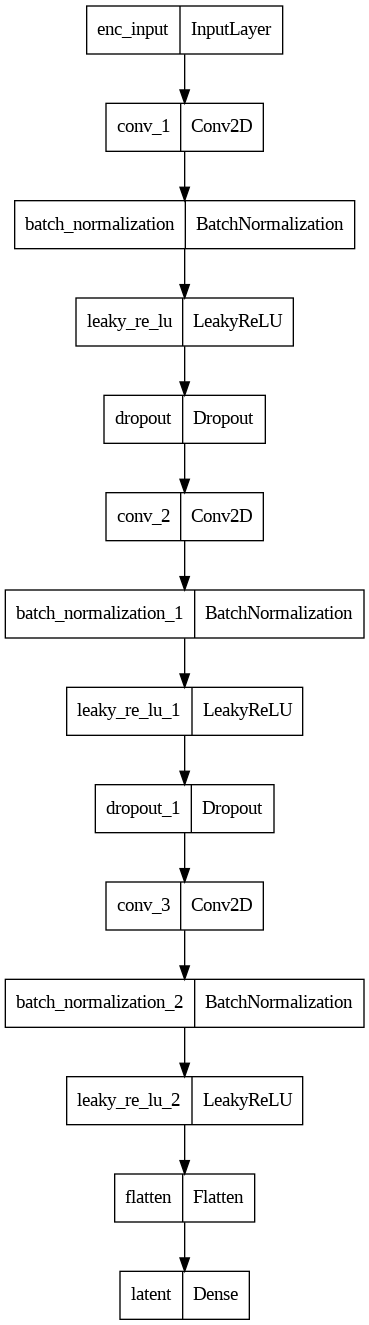

In [14]:
cnn.plot_model_graph(component='encoder')

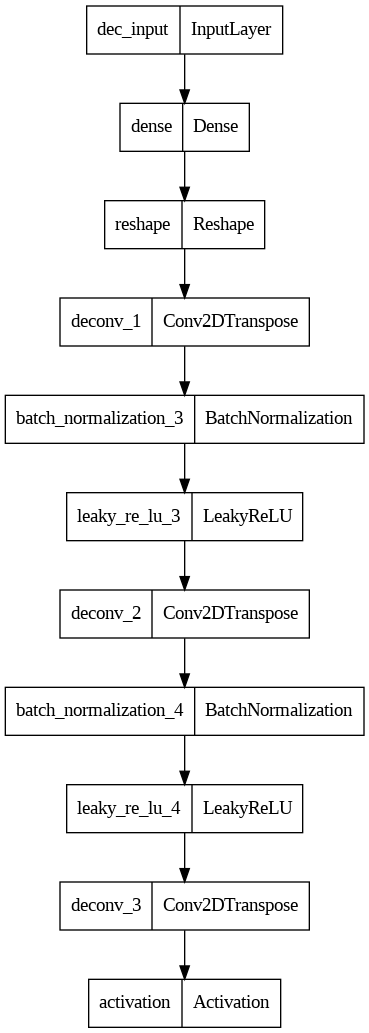

In [15]:
cnn.plot_model_graph(component='decoder')

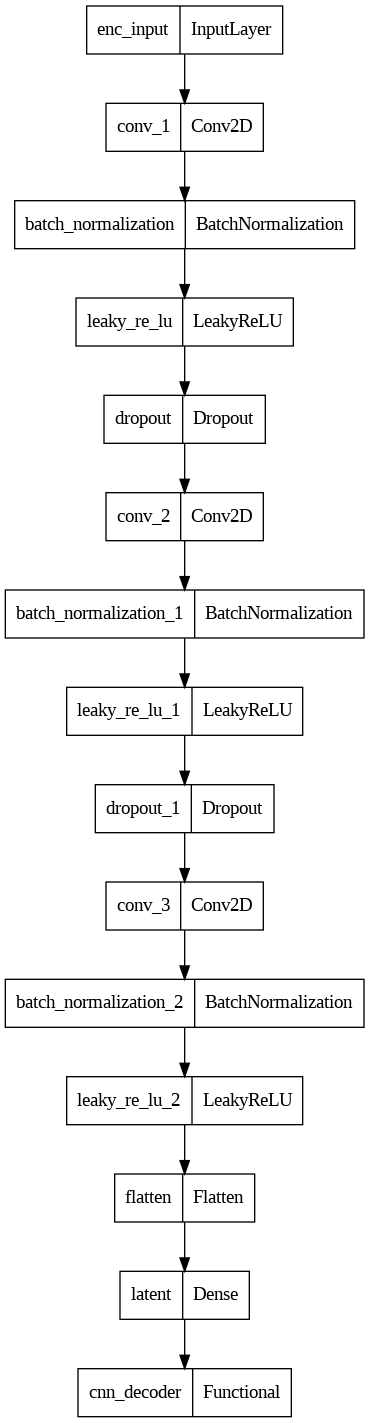

In [16]:
cnn.plot_model_graph()

### Entrenamiento

Proceso de entrenamiento del modelo:

In [ ]:
train_hist=cnn.fit_model(X_train, y_train, X_valid, y_valid, STORE_PATH, epochs=30)

Epoch 1/30
19/19 [==============================] - 1s 26ms/step - loss: 0.0238 - val_loss: 0.0287
Epoch 2/30
19/19 [==============================] - 0s 25ms/step - loss: 0.0222 - val_loss: 0.0255
Epoch 3/30
19/19 [==============================] - 0s 25ms/step - loss: 0.0210 - val_loss: 0.0235
Epoch 4/30
19/19 [==============================] - 0s 24ms/step - loss: 0.0201 - val_loss: 0.0217
Epoch 5/30
19/19 [==============================] - 0s 24ms/step - loss: 0.0194 - val_loss: 0.0206
Epoch 6/30
19/19 [==============================] - 0s 24ms/step - loss: 0.0188 - val_loss: 0.0197
Epoch 7/30
19/19 [==============================] - 0s 23ms/step - loss: 0.0184 - val_loss: 0.0191
Epoch 8/30
19/19 [==============================] - 0s 24ms/step - loss: 0.0180 - val_loss: 0.0185
Epoch 9/30
19/19 [==============================] - 0s 23ms/step - loss: 0.0177 - val_loss: 0.0183
Epoch 10/30
19/19 [==============================] - 1s 28ms/step - loss: 0.0174 - val_loss: 0.0179
Epoch 11/

Gráfico de evolución de los errores de entrenamiento y validación durante el proceso de entrenamiento:

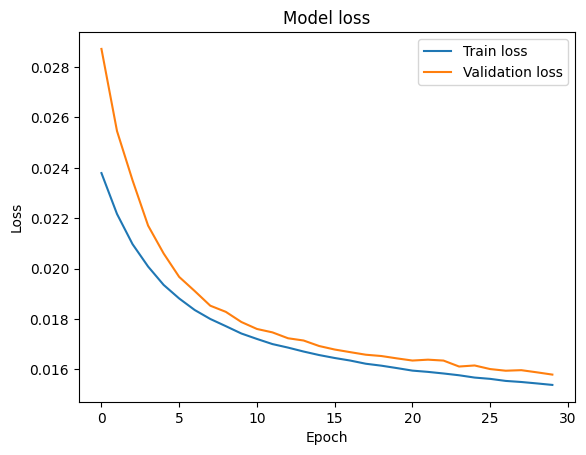

In [ ]:
cnn.plot_loss(train_hist)

### Proceso de generación

Se procede a generar nuevas piezas en base al modelo entrenado:

In [ ]:
# seed para la generación
song_name=np.random.choice(list(encoder.encoded_files.keys()))
s=encoder.encoded_files[song_name]
pianoroll = s['MAIN_TRACK']
start_ts = np.random.randint(pianoroll.shape[0]-SEQ_LEN)
s_in=pianoroll[start_ts:start_ts+SEQ_LEN,:]
print(f'Song {song_name} from ts={start_ts} to ts={start_ts+32}')

Song cs4-2all from ts=136 to ts=168


In [879]:
s_in.shape

(32, 128)

In [890]:
# SampleGenerator object
sampler = CNNSampleGenerator(cnn, encoder)

(1, 32, 128)
[[0.000e+00 4.027e+03]
 [1.000e+00 6.900e+01]]
Generated sample from ts=32 to ts=64.
[[0.000e+00 4.076e+03]
 [1.000e+00 2.000e+01]]
Generated sample from ts=64 to ts=96.
[[0.000e+00 4.084e+03]
 [1.000e+00 1.200e+01]]
Generated sample from ts=96 to ts=128.
Generated sample n.1
Saved with name cello-cnn_autoencoder_n_1.mid.


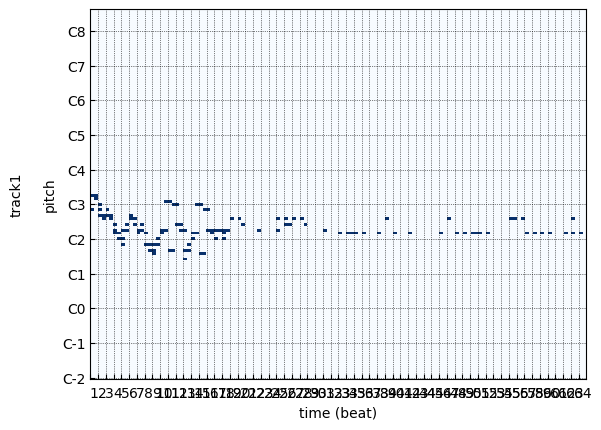

In [891]:
# Generamos una nueva pieza y se guarda en formato MIDI
sampler.generate(s_in, sample_length=3, threshold=0.2)
sampler.gen2midi()

In [ ]:
bt = pr.BinaryTrack(name='track1', pianoroll=pianoroll)
multitrack = pr.Multitrack(name='song1',tracks=[bt],resolution=2)

In [ ]:
pr.write('./coso.mid', multitrack)

#### Heatmap de probabilidades:

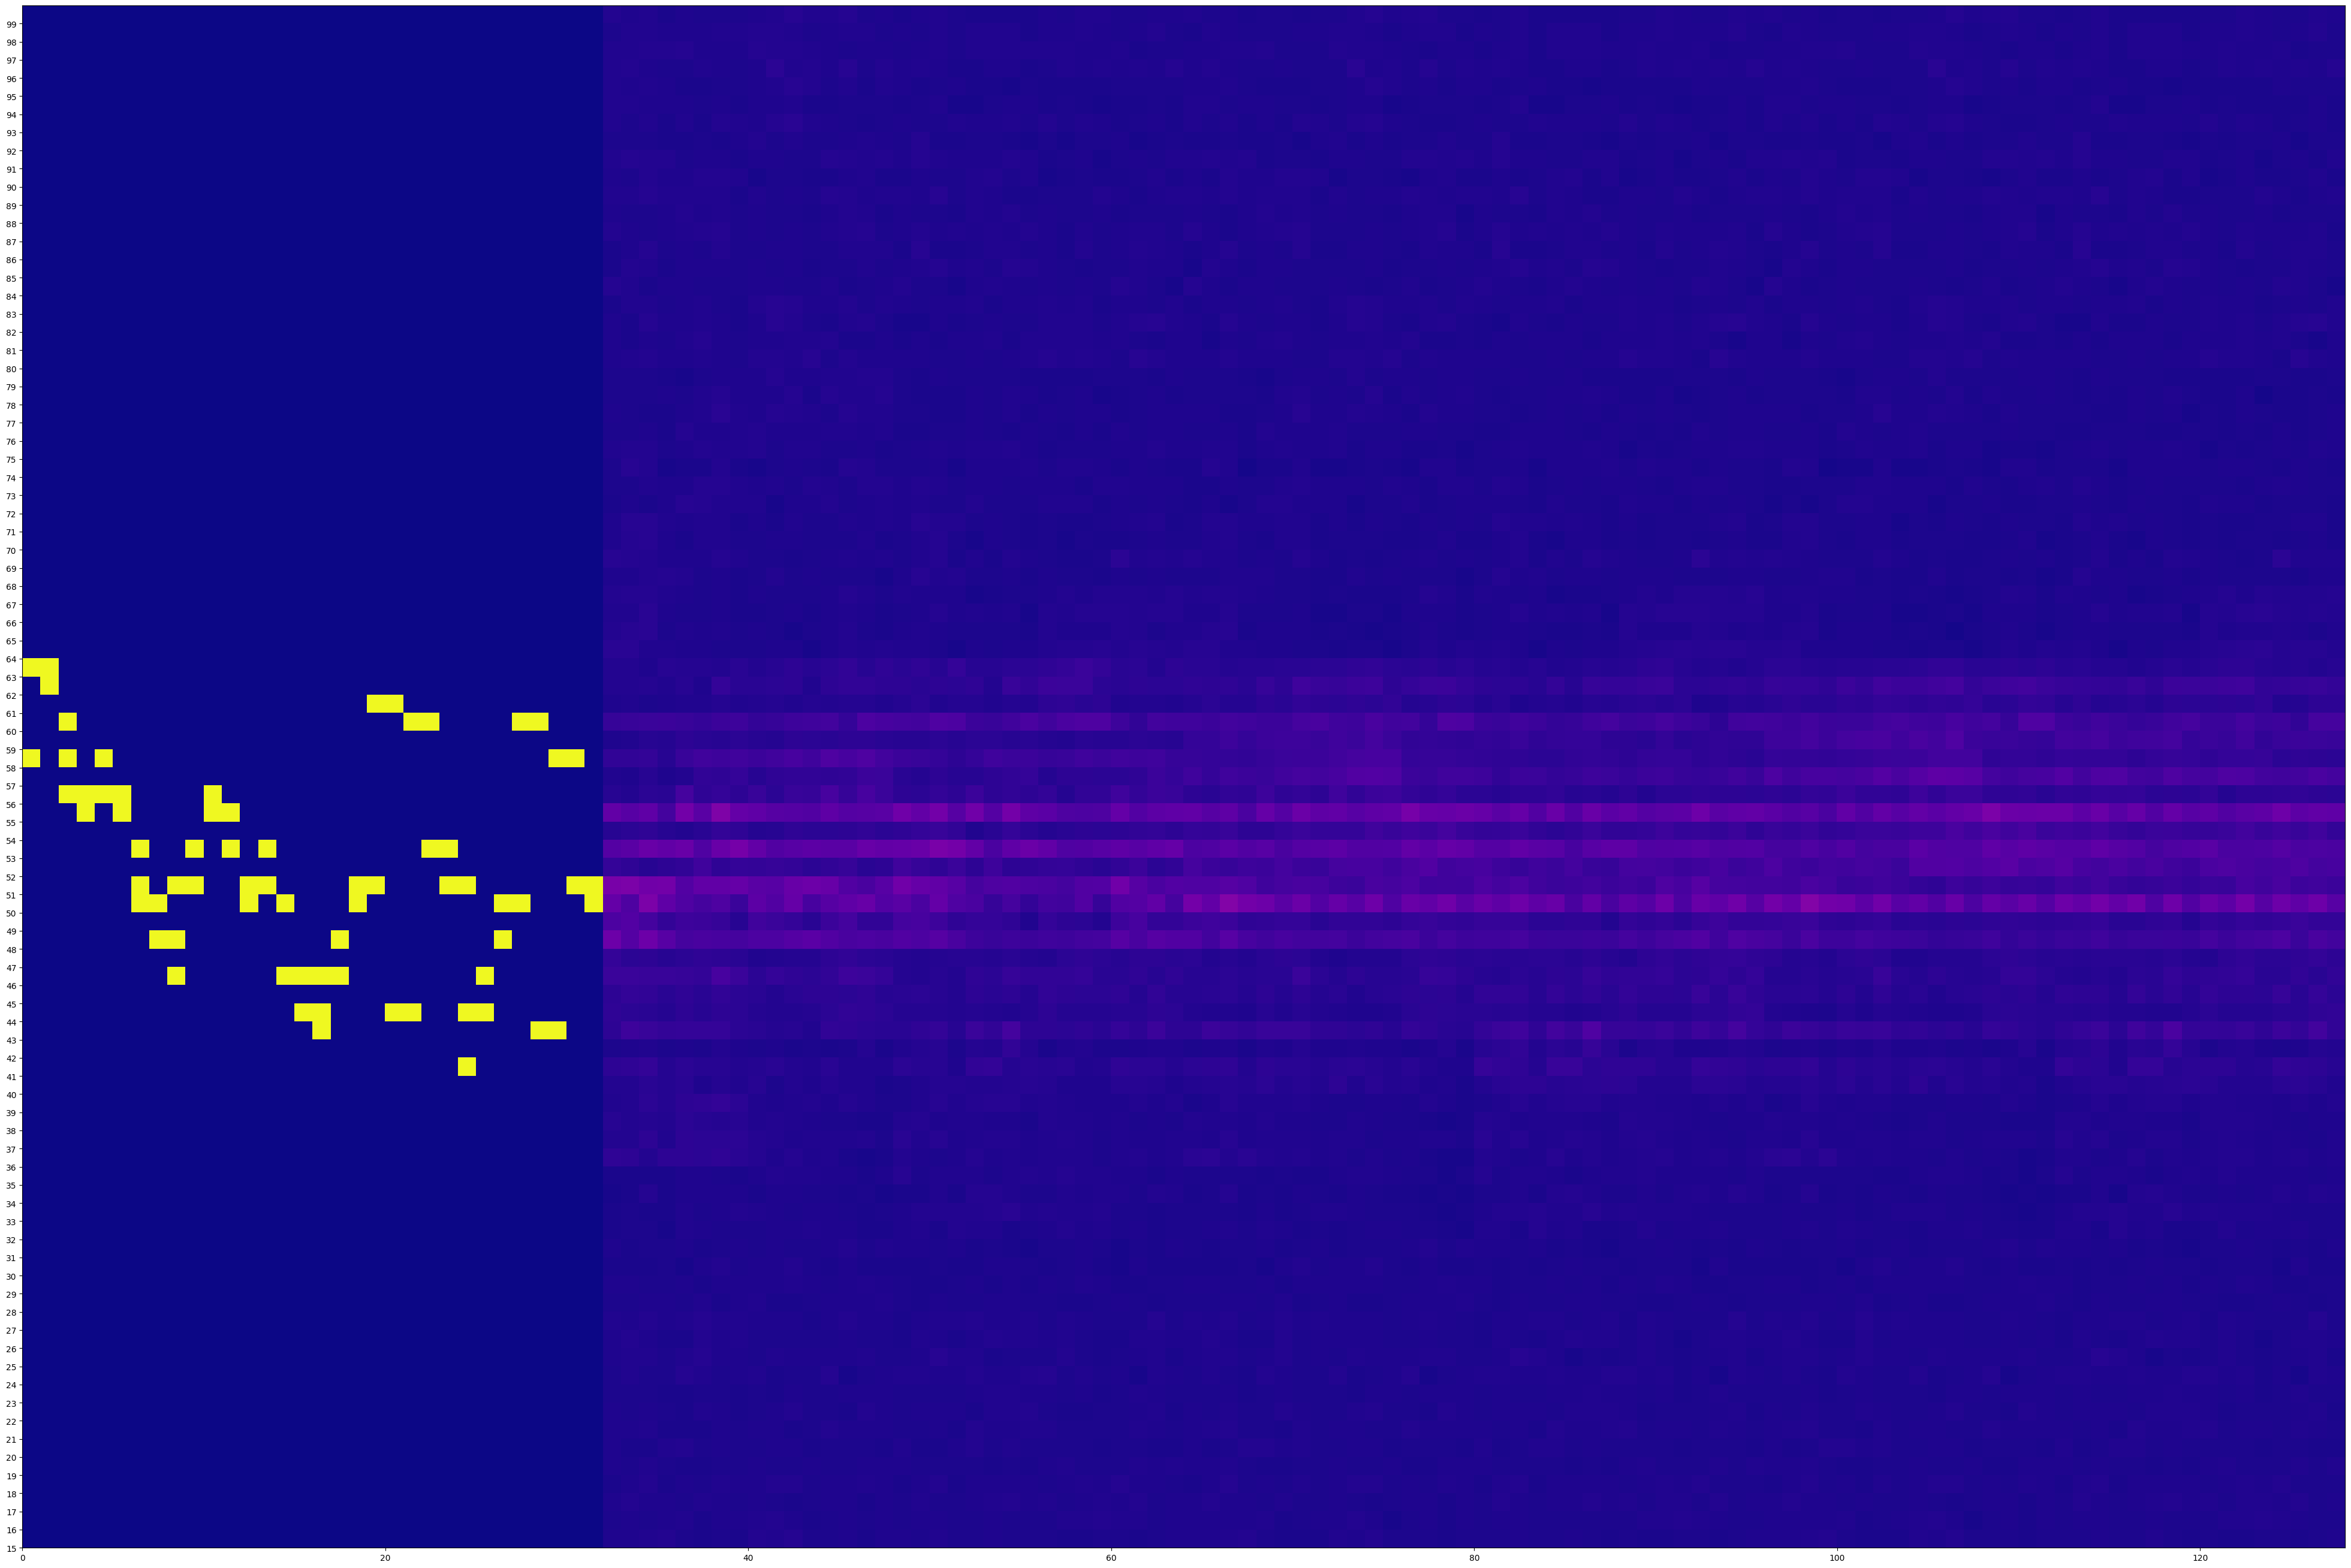

In [892]:
sampler.plot_probs_heatmap()

### Autoencoder debugging paso a paso

In [ ]:
def collapsed_rmse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=[1,2])

In [ ]:
MODEL_PATH = os.path.join(BASE_PATH, 'weights/base_conv/cello_model.h5')

In [ ]:
cello_autoencoder = keras.models.load_model(MODEL_PATH, custom_objects={'collapsed_rmse':collapsed_rmse})

In [ ]:
cnn.autoencoder = cello_autoencoder

In [ ]:
cello_autoencoder.summary()

Model: "cnn_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_input (InputLayer)      [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 128, 32)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 64, 64)        18496     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 64, 64)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 64, 128)       73856     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 64, 128)   

In [ ]:
from keras.models import Model

In [ ]:
cello_encoder= Model(inputs=cello_autoencoder.input, outputs=cello_autoencoder.get_layer('dense_26').output)

In [ ]:
cello_encoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_input (InputLayer)      [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 128, 32)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 64, 64)        18496     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 64, 64)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 64, 128)       73856     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 64, 128)       0  

In [ ]:
cello_decoder = cello_autoencoder.get_layer('cnn_decoder')

In [ ]:
p_in[p_in>0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
p_in = np.reshape(s_in, (1,32, 128))

In [ ]:
encoder_out = cello_encoder.predict(p_in)

1/1 [==============================] - 0s 64ms/step


In [ ]:
encoder_out

array([[ 28.045034 ,  26.726141 , -26.81782  ,  18.787397 , -28.856007 ,
        -10.302297 , -15.524402 ,  24.291624 ,  28.67144  ,  22.864805 ,
        -27.589104 , -23.547625 ,  28.277987 , -27.21346  ,  27.650772 ,
         16.101278 , -25.489244 , -28.83682  , -25.15083  ,  22.271095 ,
        -27.921665 , -24.325354 , -18.51132  ,  20.050303 ,  -2.9813104,
         27.043327 , -28.940636 ,  22.556269 ,  26.668158 , -25.761135 ,
        -30.706991 ,  27.622488 , -19.980145 , -26.762564 ,  21.16973  ,
         29.621979 ,  28.052168 ,  19.964235 , -28.430208 , -26.110807 ,
         29.493996 ,  16.126373 , -28.752935 , -26.929123 ,  21.632662 ,
         24.10541  ,  28.917948 ,  27.764034 , -17.553223 ,  25.473272 ,
         27.945309 ,  27.890415 ,  26.022217 ,  26.745584 ,  29.053875 ,
        -26.94474  ,  17.374283 , -26.99535  , -22.600546 , -23.477789 ,
        -26.748484 ,  27.541327 ,  26.21627  ,  28.386456 ]],
      dtype=float32)

In [ ]:
cello_decoder.layers

In [ ]:
encoder_out

array([[ 28.045034 ,  26.726141 , -26.81782  ,  18.787397 , -28.856007 ,
        -10.302297 , -15.524402 ,  24.291624 ,  28.67144  ,  22.864805 ,
        -27.589104 , -23.547625 ,  28.277987 , -27.21346  ,  27.650772 ,
         16.101278 , -25.489244 , -28.83682  , -25.15083  ,  22.271095 ,
        -27.921665 , -24.325354 , -18.51132  ,  20.050303 ,  -2.9813104,
         27.043327 , -28.940636 ,  22.556269 ,  26.668158 , -25.761135 ,
        -30.706991 ,  27.622488 , -19.980145 , -26.762564 ,  21.16973  ,
         29.621979 ,  28.052168 ,  19.964235 , -28.430208 , -26.110807 ,
         29.493996 ,  16.126373 , -28.752935 , -26.929123 ,  21.632662 ,
         24.10541  ,  28.917948 ,  27.764034 , -17.553223 ,  25.473272 ,
         27.945309 ,  27.890415 ,  26.022217 ,  26.745584 ,  29.053875 ,
        -26.94474  ,  17.374283 , -26.99535  , -22.600546 , -23.477789 ,
        -26.748484 ,  27.541327 ,  26.21627  ,  28.386456 ]],
      dtype=float32)

In [ ]:
l0 = cello_decoder.layers[0](encoder_out)
print(cello_decoder.layers[0].name)
print(l0)

dec_input
tf.Tensor(
[[ 28.045034   26.726141  -26.81782    18.787397  -28.856007  -10.302297
  -15.524402   24.291624   28.67144    22.864805  -27.589104  -23.547625
   28.277987  -27.21346    27.650772   16.101278  -25.489244  -28.83682
  -25.15083    22.271095  -27.921665  -24.325354  -18.51132    20.050303
   -2.9813104  27.043327  -28.940636   22.556269   26.668158  -25.761135
  -30.706991   27.622488  -19.980145  -26.762564   21.16973    29.621979
   28.052168   19.964235  -28.430208  -26.110807   29.493996   16.126373
  -28.752935  -26.929123   21.632662   24.10541    28.917948   27.764034
  -17.553223   25.473272   27.945309   27.890415   26.022217   26.745584
   29.053875  -26.94474    17.374283  -26.99535   -22.600546  -23.477789
  -26.748484   27.541327   26.21627    28.386456 ]], shape=(1, 64), dtype=float32)


In [ ]:
l1 = cello_decoder.layers[1](l0)
print(cello_decoder.layers[1].name)
print(l1)

dense_27
tf.Tensor([[ 2.5158765  5.781309  -7.4028263 ... -3.045957  -4.6127253 -5.711607 ]], shape=(1, 131072), dtype=float32)


In [ ]:
l2=cello_decoder.layers[2](l1)
print(cello_decoder.layers[2].name)
print(l2)

reshape_13
tf.Tensor(
[[[[ 2.5158765   5.781309   -7.4028263  ...  8.155597   -0.825825
    -4.904072  ]
   [-4.7483544   8.489149   -8.539413   ...  9.050387   -4.4479575
    -6.33209   ]
   [-2.8163357   8.767466   -6.6192927  ...  6.987852   -2.907537
    -4.7845173 ]
   ...
   [-1.0261403   6.9061737  -6.9845314  ...  8.42689    -2.1211352
    -6.3299947 ]
   [-4.0985804   8.035296   -5.208414   ...  7.5468516  -5.4410963
    -3.9179165 ]
   [-1.9921591   7.272552   -3.356821   ...  8.457171   -5.3817143
    -6.0697665 ]]

  [[-5.016197    6.004167   -4.518661   ...  5.3317084  -7.984757
     7.3652344 ]
   [-6.735937    9.684912   -6.987439   ...  2.152275   -5.9784174
    -4.278957  ]
   [-7.408337    7.84474    -6.910563   ...  5.2382617  -7.774349
    -7.191754  ]
   ...
   [-5.646018    9.603076   -7.8226647  ...  3.7661278  -6.9259796
    -6.892314  ]
   [-7.0791125   7.6951156  -6.2338786  ...  2.6975055  -7.9461107
    -4.161305  ]
   [-7.9294434   7.4481893  -6.2980156  ..

In [ ]:
l3=cello_decoder.layers[3](l2)
print(cello_decoder.layers[3].name)
print(l3)

conv2d_transpose_39
tf.Tensor(
[[[[ 38.943836  31.544588 -23.42413  ...  41.673775  26.375431
     28.139154]
   [ 40.363525  41.24036  -36.61161  ...  59.280643  41.4044
     38.447025]
   [ 40.530434  43.58769  -41.84736  ...  60.352806  40.500076
     40.32756 ]
   ...
   [ 38.577465  43.74812  -38.502068 ...  59.312943  38.890156
     41.174335]
   [ 39.291965  39.427055 -37.015945 ...  58.82185   41.215183
     40.0902  ]
   [ 18.980986  17.029116 -24.500322 ...  37.901608  26.977667
     25.945618]]

  [[ 56.079002  50.820644 -37.57349  ...  57.192818  52.76405
     41.9062  ]
   [ 67.99002   68.29351  -58.213306 ...  93.01562   68.562096
     55.985573]
   [ 69.63033   67.40735  -58.77234  ...  92.78815   70.16603
     60.20433 ]
   ...
   [ 67.932884  63.396427 -57.437862 ...  88.563446  64.828316
     59.35804 ]
   [ 66.55896   62.14233  -57.10024  ...  83.66141   65.08439
     55.7349  ]
   [ 37.619312  30.301323 -36.799232 ...  54.844067  41.084652
     33.97891 ]]

  [[ 55.

In [ ]:
l4=cello_decoder.layers[4](l3)
print(cello_decoder.layers[4].name)
print(l4)

leaky_re_lu_8
tf.Tensor(
[[[[ 38.943836   31.544588   -7.0272393 ...  41.673775   26.375431
     28.139154 ]
   [ 40.363525   41.24036   -10.983483  ...  59.280643   41.4044
     38.447025 ]
   [ 40.530434   43.58769   -12.554208  ...  60.352806   40.500076
     40.32756  ]
   ...
   [ 38.577465   43.74812   -11.550621  ...  59.312943   38.890156
     41.174335 ]
   [ 39.291965   39.427055  -11.104784  ...  58.82185    41.215183
     40.0902   ]
   [ 18.980986   17.029116   -7.350097  ...  37.901608   26.977667
     25.945618 ]]

  [[ 56.079002   50.820644  -11.272047  ...  57.192818   52.76405
     41.9062   ]
   [ 67.99002    68.29351   -17.463993  ...  93.01562    68.562096
     55.985573 ]
   [ 69.63033    67.40735   -17.631702  ...  92.78815    70.16603
     60.20433  ]
   ...
   [ 67.932884   63.396427  -17.23136   ...  88.563446   64.828316
     59.35804  ]
   [ 66.55896    62.14233   -17.130072  ...  83.66141    65.08439
     55.7349   ]
   [ 37.619312   30.301323  -11.03977   

In [ ]:
l5=cello_decoder.layers[5](l4)
print(cello_decoder.layers[5].name)
print(l5)

conv2d_transpose_40
tf.Tensor(
[[[[-1.08074160e+01 -1.60636578e+01  1.49333429e+01 ...  1.70158653e+01
     9.64703336e-02 -2.01597939e+01]
   [ 7.52222538e+00 -2.39560394e+01  1.29888411e+01 ...  1.44642735e+00
     1.57291574e+01 -1.76931572e+01]
   [-4.50862198e+01 -1.34427443e+01  1.73000259e+01 ...  3.53914642e+01
    -3.30382180e+00 -3.98747177e+01]
   ...
   [ 8.89426041e+00 -3.22973938e+01  1.50312786e+01 ...  2.45517278e+00
     1.95271358e+01 -2.40693550e+01]
   [-4.75348701e+01 -3.76750159e+00  4.85138130e+00 ...  2.95178909e+01
    -8.31688595e+00 -3.26575432e+01]
   [ 5.09803915e+00 -2.05606155e+01  8.55414963e+00 ...  2.89922881e+00
     1.21979370e+01 -1.53671551e+01]]

  [[-1.33041630e+01 -2.14869881e+01  1.19876451e+01 ...  1.44099789e+01
    -4.51809692e+00 -1.17803478e+01]
   [-9.84392166e+00 -1.58181391e+01  2.23991470e+01 ...  3.04121571e+01
     3.25526929e+00 -6.51295757e+00]
   [-3.23533287e+01 -3.01452656e+01  3.84372787e+01 ...  5.04064941e+01
     2.75419176e

In [ ]:
l6=cello_decoder.layers[6](l5)
print(cello_decoder.layers[6].name)
print(l6)

leaky_re_lu_9
tf.Tensor(
[[[[-3.24222493e+00 -4.81909752e+00  1.49333429e+01 ...  1.70158653e+01
     9.64703336e-02 -6.04793835e+00]
   [ 7.52222538e+00 -7.18681192e+00  1.29888411e+01 ...  1.44642735e+00
     1.57291574e+01 -5.30794716e+00]
   [-1.35258665e+01 -4.03282356e+00  1.73000259e+01 ...  3.53914642e+01
    -9.91146564e-01 -1.19624157e+01]
   ...
   [ 8.89426041e+00 -9.68921852e+00  1.50312786e+01 ...  2.45517278e+00
     1.95271358e+01 -7.22080660e+00]
   [-1.42604618e+01 -1.13025057e+00  4.85138130e+00 ...  2.95178909e+01
    -2.49506593e+00 -9.79726315e+00]
   [ 5.09803915e+00 -6.16818476e+00  8.55414963e+00 ...  2.89922881e+00
     1.21979370e+01 -4.61014652e+00]]

  [[-3.99124908e+00 -6.44609690e+00  1.19876451e+01 ...  1.44099789e+01
    -1.35542917e+00 -3.53410459e+00]
   [-2.95317650e+00 -4.74544191e+00  2.23991470e+01 ...  3.04121571e+01
     3.25526929e+00 -1.95388734e+00]
   [-9.70599937e+00 -9.04358006e+00  3.84372787e+01 ...  5.04064941e+01
     2.75419176e-01 -1

In [ ]:
cello_decoder.layers[7].weights

[<tf.Variable 'conv2d_transpose_41/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.07370659,  0.00962245, -0.13201514, -0.05736502,
           -0.06718591, -0.01043948, -0.06129002,  0.11781043,
            0.03930991,  0.07716038,  0.06305761,  0.10952831,
           -0.06825352, -0.04324741,  0.04894667,  0.02477586,
           -0.07953695, -0.0431023 , -0.09159931,  0.00287426,
            0.10032887, -0.14060234, -0.04876757, -0.0860716 ,
           -0.11748661, -0.14512353,  0.03807541,  0.04474178,
            0.09385206, -0.04389098,  0.11324543,  0.05198344]],
 
         [[ 0.12099554, -0.00055463, -0.04264565, -0.00064711,
            0.03448325, -0.02097735, -0.03461795, -0.08557708,
            0.05006867,  0.11812288,  0.12868465, -0.10595585,
           -0.1076342 , -0.01790748, -0.00734784, -0.01703246,
           -0.12204074, -0.05012959,  0.09598829, -0.10601254,
            0.10311479,  0.07532651, -0.14858478,  0.02693971,
            0.12781048, -0.

In [ ]:
l7=cello_decoder.layers[7](l6)
print(cello_decoder.layers[7].name)
print(l7)

conv2d_transpose_41
tf.Tensor(
[[[[ -47.441162]
   [ -89.68424 ]
   [-127.464554]
   ...
   [-153.36644 ]
   [-122.07687 ]
   [ -86.84428 ]]

  [[ -70.58846 ]
   [-158.04286 ]
   [-203.12292 ]
   ...
   [-271.33527 ]
   [-205.20848 ]
   [-163.27147 ]]

  [[-106.57338 ]
   [-226.78143 ]
   [-298.2114  ]
   ...
   [-365.78088 ]
   [-287.66925 ]
   [-207.6816  ]]

  ...

  [[-137.42726 ]
   [-223.55196 ]
   [-358.8812  ]
   ...
   [-376.55692 ]
   [-337.74265 ]
   [-224.2251  ]]

  [[ -92.79373 ]
   [-212.7017  ]
   [-264.94928 ]
   ...
   [-330.78314 ]
   [-260.59808 ]
   [-187.92722 ]]

  [[ -89.087585]
   [-108.247314]
   [-214.08981 ]
   ...
   [-179.01793 ]
   [-192.27032 ]
   [-105.255646]]]], shape=(1, 32, 128, 1), dtype=float32)


In [ ]:
l8=cello_decoder.layers[8](l7)
print(cello_decoder.layers[8].name)
print(l8)

activation_13
tf.Tensor(
[[[[2.4920979e-21]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [1.9231358e-38]]

  [[2.2070903e-31]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]], shape=(1, 32, 128, 1), dtype=float32)
